In [1]:
import numpy as np
from Bio import SeqIO
import os
import pandas as pd
import torch
import seaborn as sns
import math
import scipy.stats as stats
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from numpy import trapz
from sklearn.metrics import auc
from pathlib import Path
sns.set(font_scale=1.8, style="ticks")

/data/rbg/users/wxsh/miniconda3/envs/vaxseer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runs_folder = Path("../../../runs/flu_ah3n2_countries")
data_folder = Path("../../../data/gisaid/flu/ha_processed_countries")
saving_dir = Path("figs")

saving_dir.mkdir(parents=True, exist_ok=True)

In [3]:
subtype = "a_h3n2"
for year in list(range(2016, 2019)):
    all_test_path = data_folder / ("2003-10_to_2023-04_6M/a_h3n2/human_minBinSize10_minLen553_maxLen566_location_region2_bins/%d.fasta" % ((year - 2018) * 2 + 30))
    location_to_count = defaultdict(int)
    records = SeqIO.parse(all_test_path, "fasta")
    for record in records:
        description = record.description.split()[1]
        desc = {x.split("=")[0]: x.split("=")[1] for x in description.split("|")}
        location = desc["location"]
        location_to_count[desc["location"]] += round(float(desc["freq"]) * int(desc["bin_size"]))

# NLL & revNLL

In [4]:
subtype = "a_h3n2"
locations = ( 
    "north_america/united_states", 
    "north_america/canada",
    "europe/france",
    "europe/germany",
    "europe/russian_federation",
    "europe/spain",
    "europe/united_kingdom",
    "asia/china",
    "asia/japan",
    "oceania/australia"
)

          
def get_nlls(df):
    m = df.pivot(index='src_id', columns='src_time', values='prediction')
    m = torch.tensor(m.to_numpy())
    nlls = - (torch.logsumexp(-m, dim=-1) - math.log(m.size(1))) 
    freqs = torch.tensor(df.pivot(index='src_id', columns='src_time', values='freq').to_numpy())

    if torch.all(torch.isnan(freqs)):
        freqs = torch.ones(freqs.size()) / freqs.size(0)
        
    freqs = torch.mean(freqs, dim=1)
    freqs = freqs / torch.sum(freqs)
    
    tok_num = torch.tensor(df.pivot(index='src_id', columns='src_time', values='token_num').to_numpy())
    assert torch.all(tok_num == tok_num[:,:1])
    tok_num = tok_num[:, 0].float()
    nll = torch.sum(freqs * nlls) / torch.sum(freqs * tok_num) # 
    perplexity = torch.exp(nll)
    return nll, perplexity

def read_all_nll(path, test_path):
    if isinstance(path, Path):
        if not os.path.exists(path):
            print("path not exist", path)
            return None
        
        records = SeqIO.parse(test_path, "fasta")
        id2location = dict()
        for record in records:
            desc = record.description.split()[1].split("|")
            desc = {x.split("=")[0]: x.split("=")[1] for x in desc}
            id2location[record.id] = desc["location"]

        df = pd.read_csv(path)
        locations = []
        for src_id in df["src_id"]:
            locations.append(id2location[src_id])
        df["location"] = locations
        return df
    elif isinstance(path, dict):
        all_dfs = []
        for location, p in path.items(): 
            if not os.path.exists(p):
                print("path not exists",p)
            df = pd.read_csv(p)
            locations = [location] * len(df)
            df["location"] = locations
            all_dfs.append(df)
        return pd.concat(all_dfs)
    else:
        print("cannot access:", path)
        
        
all_nll_results = []
        
    
testing_years = list(range(2016, 2019))
    
for test_rev_dir in ("test_rev_seed_1005", "test_rev_seed_1213", "test_rev_seed_529"):
    print(">>>", test_rev_dir)

    for year in testing_years:
        print(year)
        nll_results = defaultdict(list)

        all_test_path = data_folder / ("2003-10_to_2023-04_6M/a_h3n2/human_minBinSize10_minLen553_maxLen566_location_region2_bins/%d.fasta" % ((year - 2018) * 2 + 30))


        for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
            name2nll_path = {
                    "Global": runs_folder / (f"2003-10_to_{year}-02_2M/global/test/temp_{temperature}/test_results.csv"),
                    "Prepend": runs_folder / (f"2003-10_to_{year}-02_2M/prepend/test/temp_{temperature}/test_results.csv"),
                    "Add_Embed": runs_folder / (f"2003-10_to_{year}-02_2M/concat/test/temp_{temperature}/test_results.csv"),
                    "Param_share": runs_folder / (f"2003-10_to_{year}-02_2M/param_share/test/temp_{temperature}/test_results.csv"),
                    "LoRA": {
                        location: runs_folder / f"2003-10_to_{year}-02_2M/finetune_lora/test/{location.split('/')[0]}_{location.split('/')[1]}/temp_{temperature}/lightning_logs/version_0/test_results.csv" for location in locations
                    },
                    "Finetune": {
                        location: runs_folder / f"2003-10_to_{year}-02_2M/finetune/test/{location.split('/')[0]}_{location.split('/')[1]}/temp_{temperature}/lightning_logs/version_0/test_results.csv" for location in locations
                    },
                    "Transmission(G2G)": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/continent_to_continent/agg_complete_2/test/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Transmission(G2L)": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/country_to_continent/agg_complete_2/test/temp_{temperature}/lightning_logs/version_0/test_results.csv"
                }
            model2nll = dict()
            for model in name2nll_path:
                model2nll[model] = read_all_nll(name2nll_path[model], all_test_path)
            for location in locations:
                continent, country = location.split("/")

                name2rev_nll_path = {
                    "Transmission(G2G)": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/continent_to_continent/agg_complete_2/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Transmission(G2L)": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/country_to_continent/agg_complete_2/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Param_share": runs_folder / f"2003-10_to_{year}-02_2M/param_share/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Global": runs_folder / f"2003-10_to_{year}-02_2M/global/{test_rev_dir}/{continent}/{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Prepend": runs_folder / f"2003-10_to_{year}-02_2M/prepend/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Add_Embed": runs_folder / f"2003-10_to_{year}-02_2M/concat/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "LoRA": runs_folder / f"2003-10_to_{year}-02_2M/finetune_lora/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Finetune": runs_folder / f"2003-10_to_{year}-02_2M/finetune/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                } 


                for name, _path in name2nll_path.items():
                    our_model_path_rev_nll = name2rev_nll_path[name] # os.path.join(_path, "test_rev/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (continent, temperature))

                    if os.path.exists(our_model_path_rev_nll) and model in model2nll:
                        df = model2nll[name]
                        nll, ppl = get_nlls(df[df["location"] == location])
                        df = pd.read_csv(our_model_path_rev_nll)
                        rev_nll, rev_ppl = get_nlls(df)

                        nll_results["NLL"].append(nll.item())
                        nll_results["PPL"].append(ppl.item())
                        nll_results["reverse NLL"].append(rev_nll.item())
                        nll_results["reverse PPL"].append(rev_ppl.item())
                        nll_results["temperature"].append(temperature)
                        nll_results["location"].append(location)
                        nll_results["model"].append(name)
                        nll_results["oracle"].append(test_rev_dir)

                    else:
                        if not os.path.exists(our_model_path_rev_nll):
                            print(our_model_path_rev_nll)

                        if model not in model2nll:
                            print(model)

        nll_results = pd.DataFrame(nll_results)
        nll_results["year"] = [year] * len(nll_results)

        location_to_count = defaultdict(int)
        records = SeqIO.parse(all_test_path, "fasta")
        for record in records:
            description = record.description.split()[1]
            desc = {x.split("=")[0]: x.split("=")[1] for x in description.split("|")}
            location = desc["location"]
            location_to_count[desc["location"]] += round(float(desc["freq"]) * int(desc["bin_size"]))
        nll_results["bin_size"] = [ location_to_count[x] for x in nll_results["location"] ]
        all_nll_results.append(nll_results)

all_nll_results = pd.concat(all_nll_results)
print(all_nll_results)



>>> test_rev_seed_1005
2016
2017
2018
>>> test_rev_seed_1213
2016
2017
2018
>>> test_rev_seed_529
2016
2017
2018
          NLL       PPL  reverse NLL  reverse PPL  temperature  \
0    0.219172  1.245046     0.008483     1.008519          0.2   
1    0.214402  1.239121     0.007848     1.007879          0.2   
2    0.227351  1.255271     0.008398     1.008434          0.2   
3    0.268098  1.307475     0.048649     1.049852          0.2   
4    0.223566  1.250528     0.007920     1.007952          0.2   
..        ...       ...          ...          ...          ...   
395  0.057196  1.058864     0.029857     1.030307          1.0   
396  0.054484  1.055996     0.031088     1.031576          1.0   
397  0.059971  1.061806     0.022115     1.022361          1.0   
398  0.058015  1.059730     0.018725     1.018901          1.0   
399  0.060010  1.061847     0.019543     1.019735          1.0   

                        location              model              oracle  year  \
0    north_am

In [5]:
orig_all_nll_results = all_nll_results

In [6]:
all_nll_results = orig_all_nll_results[orig_all_nll_results["bin_size"] >= 100]

In [7]:
all_nll_results

,NLL,PPL,reverse NLL,reverse PPL,temperature,location,model,oracle,year,bin_size
0,0.219172,1.245046,0.008483,1.008519,0.2,north_america/united_states,Global,test_rev_seed_1005,2016,3573
1,0.214402,1.239121,0.007848,1.007879,0.2,north_america/united_states,Prepend,test_rev_seed_1005,2016,3573
2,0.227351,1.255271,0.008398,1.008434,0.2,north_america/united_states,Add_Embed,test_rev_seed_1005,2016,3573
3,0.268098,1.307475,0.048649,1.049852,0.2,north_america/united_states,Param_share,test_rev_seed_1005,2016,3573
4,0.223566,1.250528,0.007920,1.007952,0.2,north_america/united_states,LoRA,test_rev_seed_1005,2016,3573
...,...,...,...,...,...,...,...,...,...,...
395,0.057196,1.058864,0.029857,1.030307,1.0,oceania/australia,Param_share,test_rev_seed_529,2018,452
396,0.054484,1.055996,0.031088,1.031576,1.0,oceania/australia,LoRA,test_rev_seed_529,2018,452
397,0.059971,1.061806,0.022115,1.022361,1.0,oceania/australia,Finetune,test_rev_seed_529,2018,452
398,0.058015,1.059730,0.018725,1.018901,1.0,oceania/australia,Transmission(G2G),test_rev_seed_529,2018,452


In [8]:
NLL_KEY = "NLL"
REV_NLL_KEY ="reverse NLL"

def get_summary(df, keys=("model", "temperature", "year"), weighted_average=True, nll_key=NLL_KEY, rev_nll_key=REV_NLL_KEY):
    summary_nll_results = defaultdict(list)
    for x in zip(*(df[key] for key in keys)):
        _df = df
        for i, key in enumerate(keys):
            _df = _df[_df[key] == x[i]]
        
        if weighted_average:
            ave_nll = np.sum(_df["bin_size"] * _df[nll_key]) / np.sum(_df["bin_size"])
            ave_rev_nll = np.sum(_df["bin_size"] * _df[rev_nll_key]) / np.sum(_df["bin_size"])
        else:
            ave_nll = np.mean(_df[nll_key])
            ave_rev_nll = np.mean(_df[rev_nll_key])
        
        for i, key in enumerate(keys):
            summary_nll_results[key].append(x[i])
        summary_nll_results[nll_key].append(ave_nll)
        summary_nll_results[rev_nll_key].append(ave_rev_nll)
        summary_nll_results["toal_sample_size"].append(np.sum(_df["bin_size"]))

    summary_nll_results = pd.DataFrame(summary_nll_results)
    summary_nll_results = summary_nll_results.drop_duplicates()
    return summary_nll_results

In [9]:
def plot(summary_summary_df, fig_title, fig_save_path, hide_legend=False):
    plt.xscale('log')
    plt.yscale('log')

    plt.rcParams['lines.markersize'] = 15
    
    ori_our_model_name_1 = "Transmission(G2G)"
    our_model_name_1 = r'$\bf{Transmission(G2G)}$' # r'$\bf{Bold}$'
    
    ori_our_model_name_2 = "Transmission(G2L)"
    our_model_name_2 = r'$\bf{Transmission(G2L)}$' # r'$\bf{Bold}$'
    
    summary_summary_df["model"] = [
        x if (x != ori_our_model_name_1 and x != ori_our_model_name_2) 
        else r'$\bf{%s}$' % x for x in summary_summary_df["model"]]

    
    models = list(set(summary_summary_df["model"]))
    models.sort()
    style_dict = {}
    for model in models:
        if model == our_model_name_1 or model == our_model_name_2:
            style_dict[model] = ""
        else:
            style_dict[model] = (2,2)
    
    style_order =  [our_model_name_1, our_model_name_2,  'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']

    # color dict
    palette_light = sns.color_palette("Set2", n_colors=8) # pastel
    palette_dark = sns.color_palette("hls", n_colors=8)
    color_dict = {}
    
    models.remove(our_model_name_1)
    models.remove(our_model_name_2)
    
    for i, model in enumerate(models):
        color_dict[model] = palette_light[i]
    color_dict[our_model_name_1] = palette_dark[5]
    color_dict[our_model_name_2] = palette_dark[0]

    ax = sns.lineplot(summary_summary_df, x="NLL", y="reverse NLL", hue="model", markers=True, # marker='o', 
                      sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order) # , size=20 ,linewidth = 1.5

    ax.set_title(fig_title)
    ax.set_xlabel("NLL")
    ax.set_ylabel("reverse NLL")

    if hide_legend:
        plt.legend([],[], frameon=False)
    else:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    

    plt.savefig(fig_save_path, format='pdf', bbox_inches='tight')

    plt.show()

europe/spain 200


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


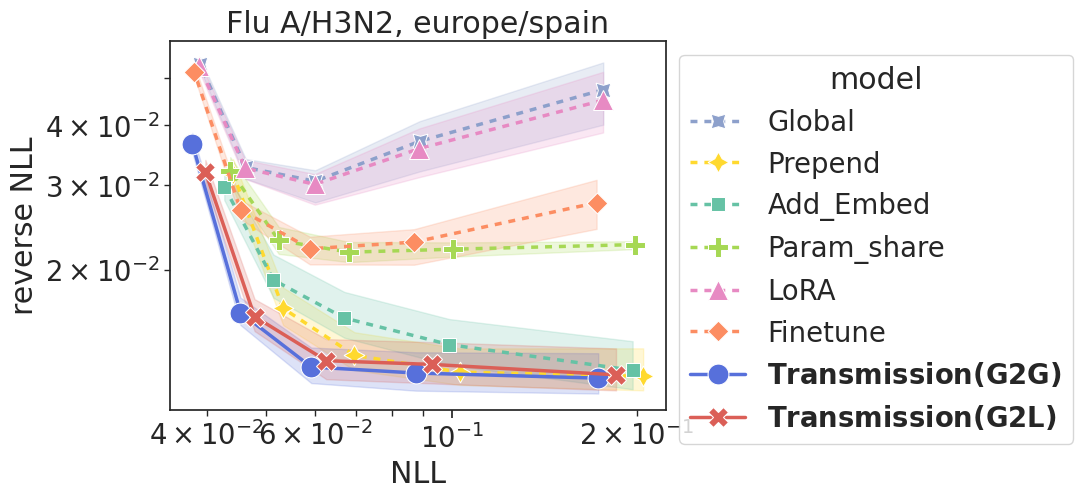

asia/china 215


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


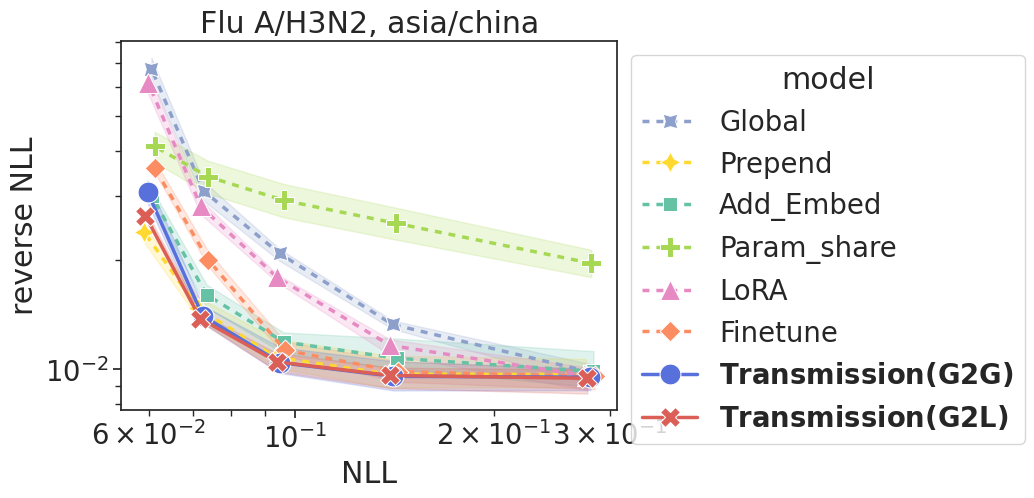

europe/germany 536


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


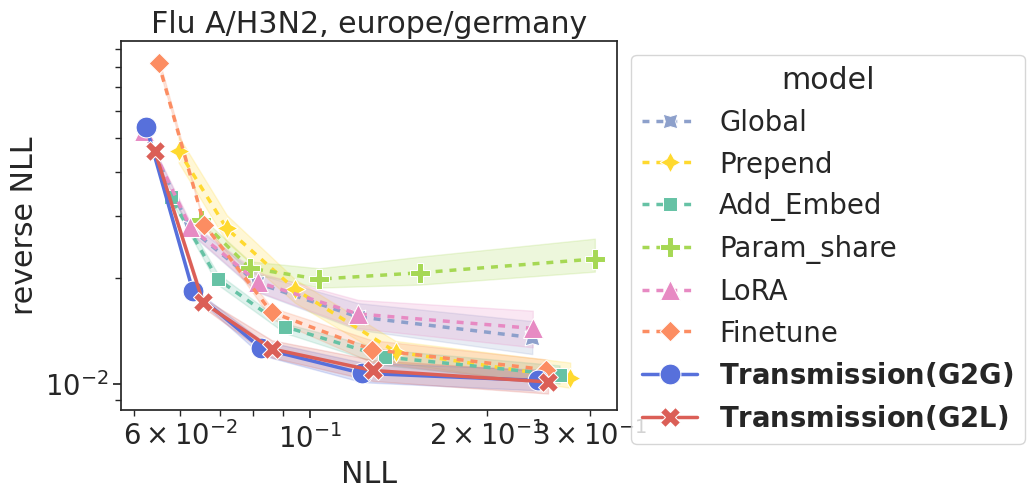

europe/russian_federation 659


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


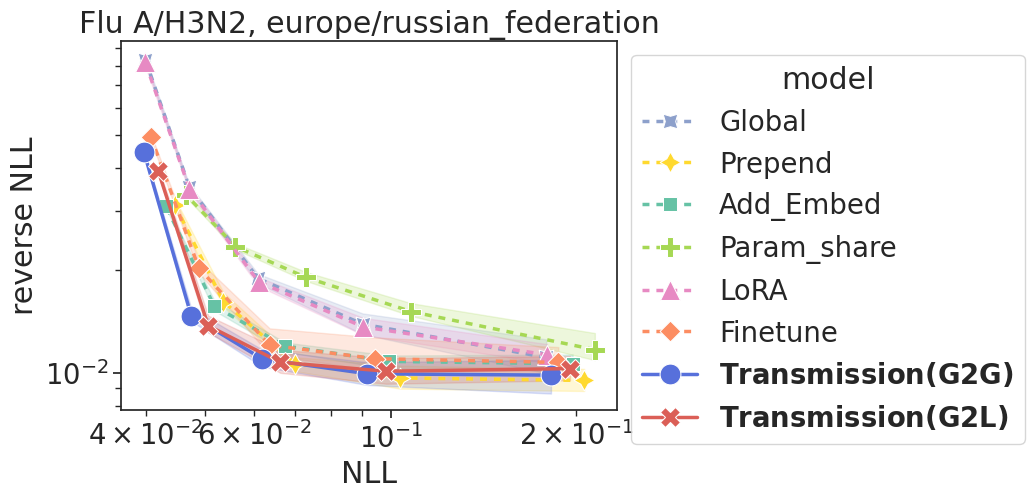

europe/france 915


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


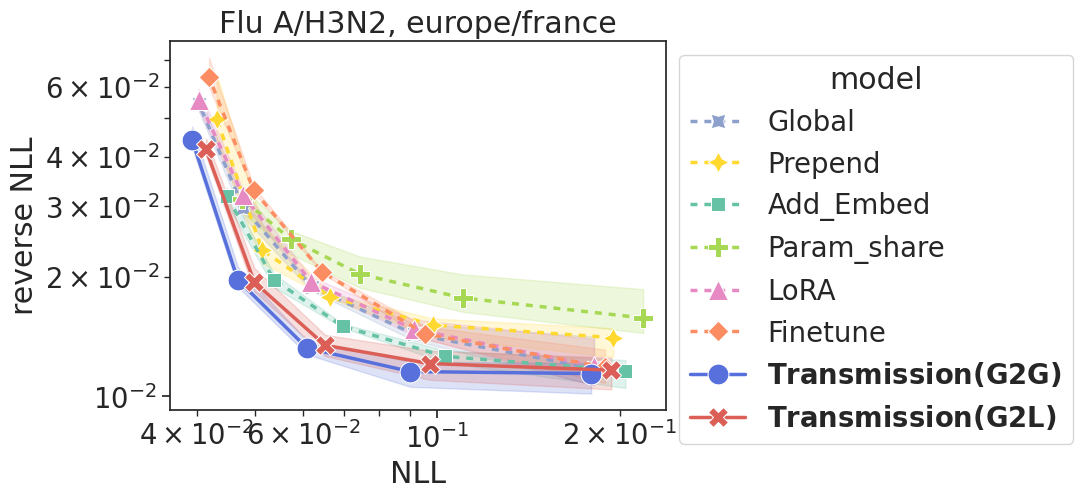

asia/japan 995


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


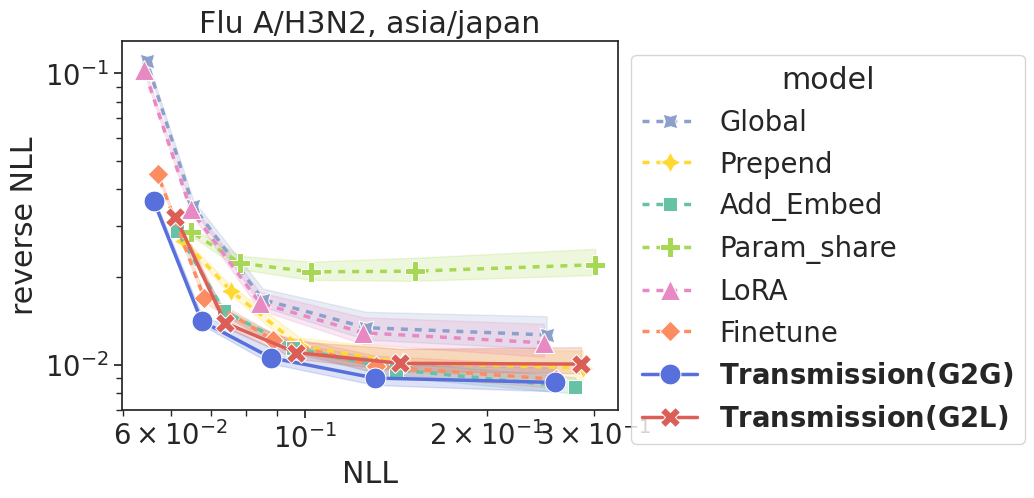

oceania/australia 1189


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


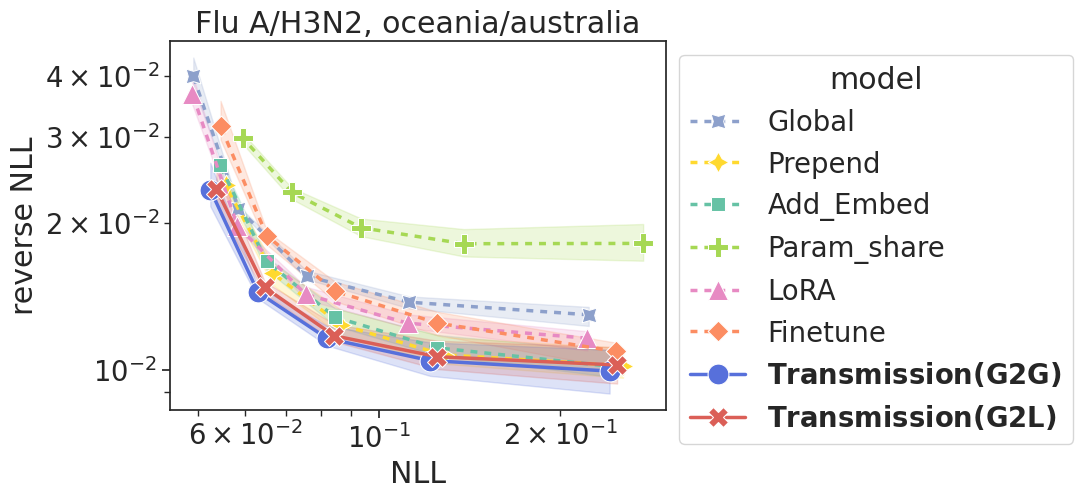

europe/united_kingdom 1220


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


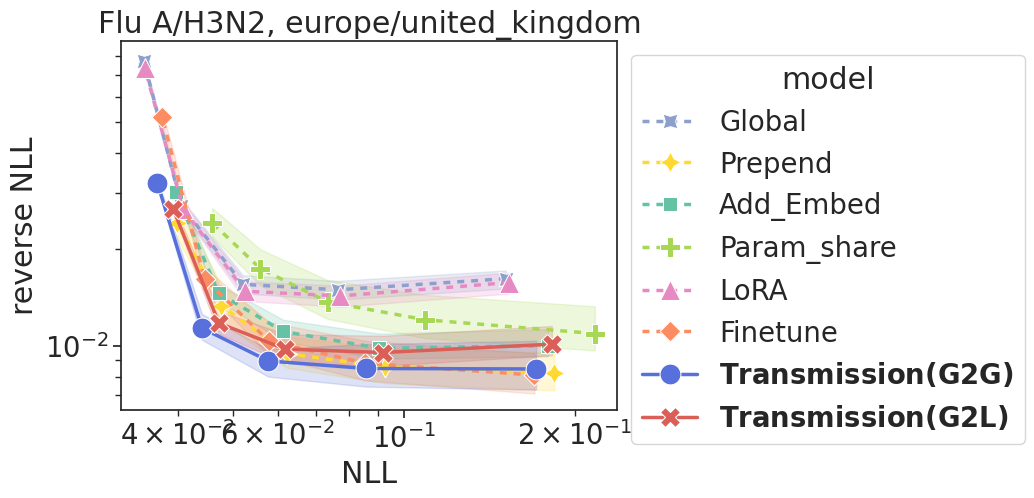

north_america/canada 1559


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


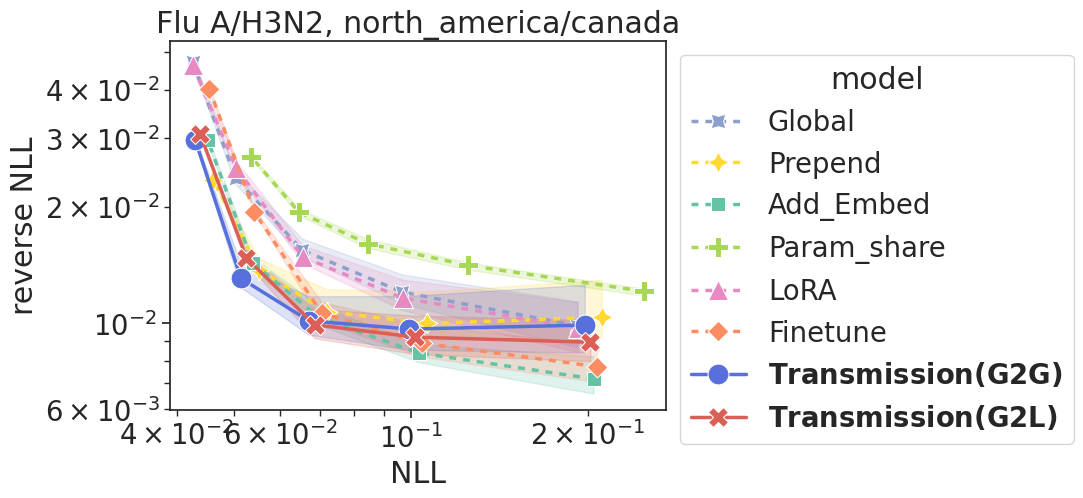

north_america/united_states 11037


/tmp/ipykernel_518176/21664947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


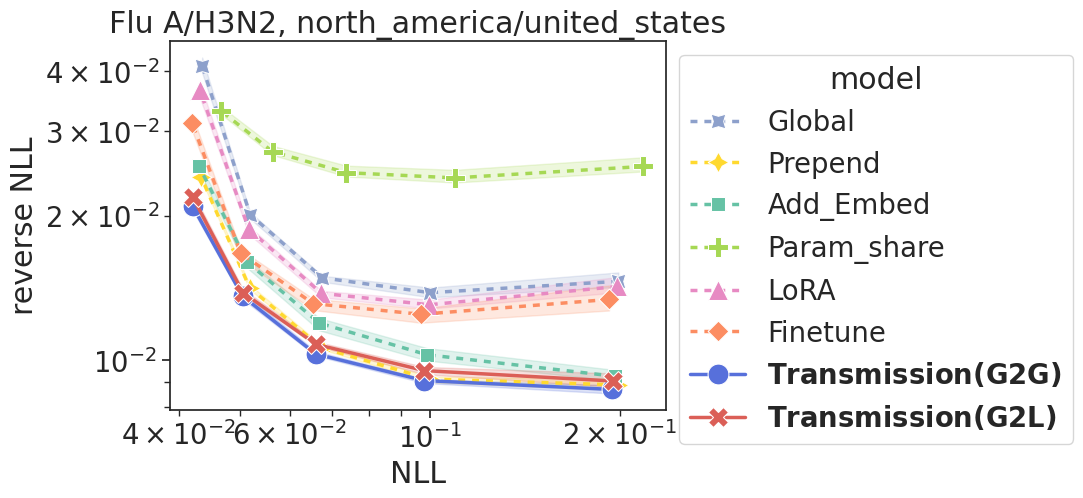

In [10]:
min_count = 200

local_summary_df = get_summary(all_nll_results[all_nll_results["bin_size"] >= min_count], keys=("model", "temperature", "location", "oracle"))
sorted_locations = sorted(dict(zip(local_summary_df["location"], local_summary_df["toal_sample_size"])).items(), key=lambda x: x[1])

file_names = []

for location, ss in sorted_locations:
    print(location, ss)
    
    local_df = local_summary_df[local_summary_df["location"] == location]
    if len(local_df) <= 0:
        continue
    
    plot(local_df, "Flu %s, %s" % (subtype.upper().replace("_", "/"), location), 
         saving_dir / ("flu_country_%s.pdf" % location.replace("/", "_")))
    
    file_names.append("flu_country_%s.pdf" % location.replace("/", "_") )

['Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend', 'Transmission(G2G)', 'Transmission(G2L)']


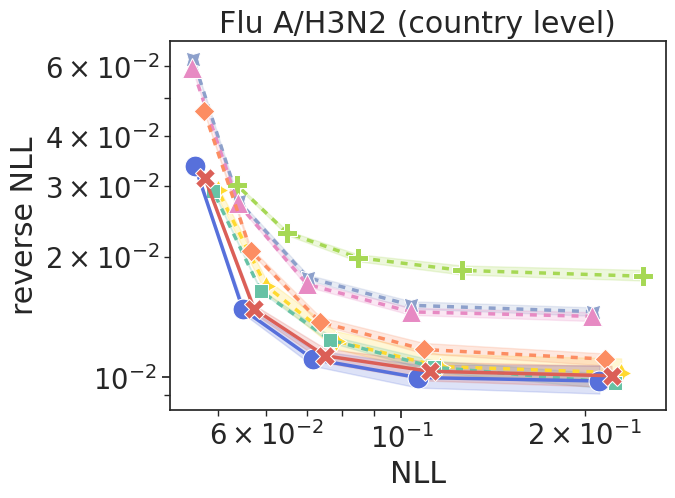

In [11]:
summary_summary_df = get_summary(all_nll_results[all_nll_results["bin_size"] >= 200], keys=("model", "temperature", "oracle"), weighted_average=False)

plt.xscale('log')
plt.yscale('log')

plt.rcParams['lines.markersize'] = 15

models = list(set(summary_summary_df["model"]))
models.sort()

print(models)

style_dict = {}
for model in models:
    if model == "Transmission(G2G)" or model == "Transmission(G2L)":
        style_dict[model] = ""
    else:
        style_dict[model] = (2,2)
        
style_order = models
style_order =  ['Transmission(G2G)', 'Transmission(G2L)', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']
# color dict
palette_light = sns.color_palette("Set2", n_colors=8) # pastel
palette_dark = sns.color_palette("hls", n_colors=8)
color_dict = {}

for i, model in enumerate(models):
    color_dict[model] = palette_light[i]
color_dict["Transmission(G2G)"] = palette_dark[5]
color_dict["Transmission(G2L)"] = palette_dark[0]

ax = sns.lineplot(summary_summary_df, x=NLL_KEY, y=REV_NLL_KEY, hue="model", markers=True, # marker='o', 
                  sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order) # , size=20 ,linewidth = 1.5
ax.set_title("Flu %s (country level)" % (subtype.upper().replace("_", "/")))

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.05))
plt.legend([],[], frameon=False)


plt.savefig(saving_dir / "main_res_flu_country_average.pdf", format='pdf', bbox_inches='tight')

plt.show()


In [12]:
def calculate_ci(data):
    # Calculate sample mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)

    # Calculate the 95% confidence interval
    confidence = 0.95
    alpha = 1 - confidence

    # For large samples, use z-distribution
    z_critical = stats.norm.ppf(1 - alpha / 2)

    # For small samples, use t-distribution
#     t_critical = stats.t.ppf(1 - alpha / 2, df=n-1) # Uncomment for small samples

    # Margin of error
    margin_of_error = z_critical * (std_dev / np.sqrt(n))
#     margin_of_error = t_critical * (std_dev / np.sqrt(n)) # Uncomment for small samples

    # Confidence interval
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    
#     print(mean)
#     print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")
    
    return mean, ci_lower, ci_upper
    

def print_markdown_table(df, temp, group_by=("model",), values=("reverse NLL", 'NLL')):
    # df = df.drop_duplicates()
    res_dict = dict()
    for i, row in df.iterrows():
        key = tuple(row[x] for x in group_by)
        if key not in res_dict:
            res_dict[key] = defaultdict(list)
        for value in values:
            res_dict[key][value].append(row[value])    
    
    new_table = []
    rev_nll_cis = dict()
    for key in res_dict:
        ci = calculate_ci(res_dict[key]["reverse NLL"])
        new_table.append(
            { 'model': key[0], 'NLL': res_dict[key]["NLL"][0], "reverse NLL": ci[0], 'ci_lower': ci[1], 'ci_upper': ci[2]}
        )
        model_name = key[0].replace('_', '\\_')
        if  "Transmission" in model_name:
            model_name = "{\\bf %s}" % model_name
        x = f"{model_name} & {temperature} &  {res_dict[key]['NLL'][0]:.4f} & {ci[0]:.4f} ({ci[1]:.4f}, {ci[2]:.4f}) \\\\"
        print(x)    
    
    df = pd.DataFrame(new_table)        
    
    return res_dict, rev_nll_cis

# print(summary_summary_df)
for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
    _, table = print_markdown_table(summary_summary_df[summary_summary_df["temperature"] == temperature], temperature)
    print("\midrule")

Global & 0.2 &  0.2061 & 0.0146 (0.0142, 0.0150) \\
Prepend & 0.2 &  0.2294 & 0.0103 (0.0094, 0.0111) \\
Add\_Embed & 0.2 &  0.2243 & 0.0097 (0.0092, 0.0102) \\
Param\_share & 0.2 &  0.2494 & 0.0179 (0.0172, 0.0185) \\
LoRA & 0.2 &  0.2058 & 0.0142 (0.0138, 0.0146) \\
Finetune & 0.2 &  0.2162 & 0.0111 (0.0107, 0.0115) \\
{\bf Transmission(G2G)} & 0.2 &  0.2113 & 0.0098 (0.0089, 0.0107) \\
{\bf Transmission(G2L)} & 0.2 &  0.2213 & 0.0101 (0.0094, 0.0108) \\
\midrule
Global & 0.4 &  0.1038 & 0.0151 (0.0148, 0.0155) \\
Prepend & 0.4 &  0.1155 & 0.0106 (0.0099, 0.0114) \\
Add\_Embed & 0.4 &  0.1131 & 0.0106 (0.0102, 0.0110) \\
Param\_share & 0.4 &  0.1256 & 0.0185 (0.0180, 0.0191) \\
LoRA & 0.4 &  0.1036 & 0.0146 (0.0142, 0.0149) \\
Finetune & 0.4 &  0.1089 & 0.0117 (0.0113, 0.0122) \\
{\bf Transmission(G2G)} & 0.4 &  0.1063 & 0.0100 (0.0092, 0.0108) \\
{\bf Transmission(G2L)} & 0.4 &  0.1112 & 0.0104 (0.0097, 0.0110) \\
\midrule
Global & 0.6 &  0.0702 & 0.0177 (0.0174, 0.0181) \\
Prepend 

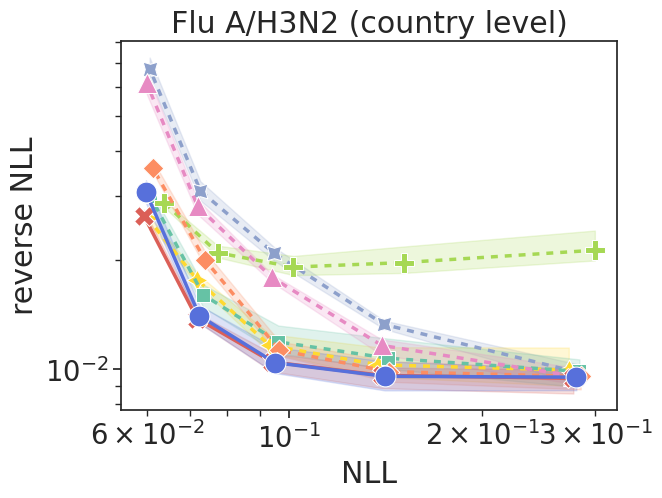

In [13]:
summary_summary_df = get_summary(all_nll_results[all_nll_results["bin_size"] >= 200], 
                                 keys=("model", "temperature", "oracle", "location"), weighted_average=False)

def get_worset_location(df, key="NLL", temp=1.0):
    _df = df[df["temperature"] == temp]
    loc2nlls = defaultdict(list)
    for loc, nll in zip(_df["location"], _df[key]):
        loc2nlls[loc].append(nll)
    loc2nlls = {k: np.mean(v) for k, v in loc2nlls.items()}
    return sorted(loc2nlls.items(), key=lambda x: x[1], reverse=True)[0]
    
new_df = []
for model in ['Global', 'Prepend', 'Add_Embed', 'Param_share', 'LoRA', 'Finetune', 'Transmission(G2L)', 'Transmission(G2G)']:
    _df = summary_summary_df[summary_summary_df["model"] == model]
    location = get_worset_location(_df)[0]
    _df = _df[_df["location"] == location]
    new_df.append(_df)

new_df = pd.concat(new_df)

plot(new_df, "Flu %s (country level)" % (subtype.upper().replace("_", "/")), 
         saving_dir / "main_res_flu_country_worse.pdf", hide_legend=True)
